# Order 
The order of a numerical scheme for
$y' = f(y)$ with $y(0)=y_0$
describes how fast the error in a single step goes to zero as a function of 
the step size $h$. If the exact solution is $y(t)$ and the approximation after one time step is $y_1(h)$
then the error (called the Local Truncation Error) is 
$$
LTE(h)=y_1(h)-y(h)  
$$
The first term in a Taylor series for the LTE is zero since 
$$LTE(0)=y_1(0)-y(0)=y_0 - y_0=0$$
The coefficients for the fancy RK schemes are chosen carefully 
so that $LTE'(0)=0$ and $LTE''(0)=0$ etc. The order of the scheme is how far up the terms match. In other words
$$
LTE(h) = O(h^{order+1}).
$$


### Euler's Method
For Euler's method 
$y_1(h) = y_0 + h f(y_0) $
the computation is simple.
$$
LTE_e(h) = y_0 + h f(y_0) - y(h)
$$
so the constant $h^0$ term is $LTE(0)=y_0 - y(0)=0$. To get the 
linear $h^1$ term we need to differentiate
$$
LTE_e'(h) = 0 + f(y_0) - y'(h) = f(y0)-f(y(h))
$$
and evaluate at $h=0$ to get
$LTE_e'(0) = f(y_0) - f(y(0))=f(y_0) - f(y_0)=0$. 
For the quadratic $h^2$ term differentiate again 
$$
LTE_e''(h) = \frac{d}{dh} \left( f(y0)-f(y(h)) \right) = 0 - Df(y(h))y'(h)= 0 - Df(y(h))f(y(h))
$$
and evaluate at $h=0$ to get
$LTE_e''(0) =-Df(y_0) f(y_0) \neq 0$.  So for Euler's method 
$$
LTE_e(h) = -Df(y_0) f(y_0) \frac{h^2}{2} = O(h^2)
$$
Euler's method has order one. 

### Explicit MidPoint Scheme
For the explicit MidPoint scheme 
$$
\begin{align}
y_{mid} &= y_0 + 0.5 h f(y_0) \\
y_{1} &= y_0 + h f(y_{mid})
\end{align}
$$ 
the LTE is 
$$
LTE_m(h) = y_0 + h f(y_0 + 0.5 h f(y_0)) - y(h)
$$
and 
$$
LTE_m'(h) = 0 + f(y_0 + 0.5 h f(y_0)) + h  Df(y_0 + 0.5 h f(y_0))f(y_0)-y'(h)
$$
evaluating at $h=0$ gives 
$$
LTE_m'(0) = f(y_0) - y'(0)=f(y_0)-f(y_0)=0
$$
The explicit mid point method has order at least one!  Differentiating again is going to be messy. Numerically
it is easy to check the order. 

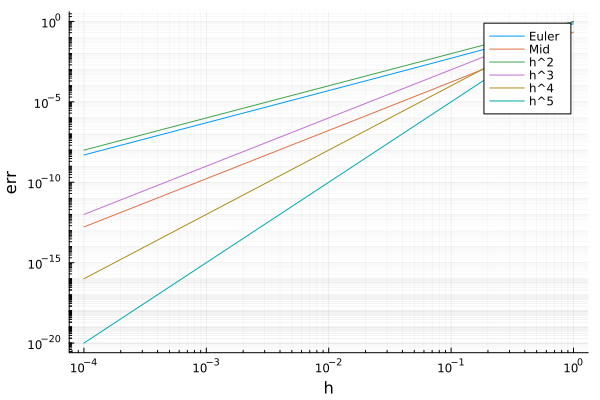

In [8]:
function EulerStep(f,y,h)
    k1=f(y)
    y + h*k1
end

function MidStep(f,y,h)
    k1 = f(y)
    zMid = y + 0.5*h*k1
    kMid = f(zMid)
    y + h*kMid
end

function TrapStep(f,y,h)
    k1 = f(y)
    z2 = y + 1.0*h*k1
    k2 = f(z2)
    y + h*(0.5*k1 + 0.5*k2)
end

function test(y)
    y
end

function LTEe(h)
    abs(EulerStep(test,1.0,h) - exp(h))
end

function LTEm(h)
    abs(MidStep(test,1.0,h) - exp(h))
end

function LTEt(h)
    abs(TrapStep(test,1.0,h) - exp(h))
end

hs = 0.0001:0.0001:1.0

using Plots
plot(hs,[LTEe.(hs) LTEm.(hs) hs.^2 hs.^3 hs.^4 hs.^5],
xlabel="h", ylabel="err",
xscale=:log10, yscale=:log10, minorgrid=true, label=["Euler" "Mid" "h^2" "h^3" "h^4" "h^5" "h^13"] )


### General Explicit RK scheme
A general RK scheme is defined by a strictly lower triangular matrix 
$A$ which specifies the sequential evaluations of the internal slopes
from the function $f$ and a vector $b$ which specifies how to 
average the slopes together to compute $y_{n+1}$. The size of the vector 
$b$ (or equivalently the square matrix $A$) is the number of internal stages and 
measures how complicated the scheme is.  

The standard 
terminology uses $z_i$ for the sequentially computed internal stages 
and $k_i = f(z_i)$ for the internal stage slopes through
$$
z_i = y_n + h_n \left( \sum_{j=1}^{s} a_{i,j} k_j \right)  
\quad
\mbox{with}
\quad
k_i = f(z_i)
$$
and the external step is computed from the stage slopes through
$$
y_{n+1} = y_n + h_n \sum_{j=1}^s b_j k_j
$$

In the real world solvers include two different $b$ vectors.  One is used to advance the scheme and the other is used to adjust the step size $h_n$ to control the error. 

We are going to write a stepper for either the mid point or trapezoid rule and one of the rk schemes from the wiki page. 

Then we are going to write a general solver which performs a general RK step from a Butcher Tableau.  We are going to store the data as a structure.

# Code

In [1]:
struct RKTable
    A::Matrix{Float64}
    b::Vector{Float64}
    bHat::Vector{Float64}
end

function RKStep(yOld,h,f,scheme::RKTable)
    # extract RK scheme
    A=scheme.A; b=scheme.b; bHat=scheme.bHat
    # Extract dimension of ODE and stages of scheme
    n=size(yOld)[1];s=size(A)[1]
    # Assign space for the function evaluations
    K = zeros(n,s)
    # Compute slopes Ks
    for i in 1:s
        # Assign Appropriate Slopes
        z = yOld
        for j in 1:i-1
            z+=h*(A[i,j]*K[:,j])
        end
        K[:,i] = f(z)
    end
    
    # Compute the outputs
    y=copy(yOld)
    yHat=copy(yOld)
    for i in 1:s 
        y+=h*b[i]*K[:,i]
        yHat+=h*bHat[i]*K[:,i]
    end
    # Return the outputs 
    [y yHat]
end

TrapTable = RKTable([
    [0 0]
    [1 0]],
    [1/2,1/2],[0,0])

A=[
    [0 0 0 0 0 0]
    [1//4 0 0 0 0 0]
    [3//32 9//32 0 0 0 0 ]
    [1932//2197 -7200//2197 7296//2197 0 0 0]
    [439//216 -8 3680//513 -845//4104 0 0]
    [-8//27 2 -3544//2565 1859//4104 -11//40 0]
    ]
b = [16//135, 0, 6656//12825, 28561//56430, -9//50, 2//55]
bHat = [25//216, 0, 1408//2565, 2197//4104, -1//5, 0] 
RKF45 = RKTable(A, b, bHat)

RKTable([0.0 0.0 … 0.0 0.0; 0.25 0.0 … 0.0 0.0; … ; 2.0324074074074074 -8.0 … 0.0 0.0; -0.2962962962962963 2.0 … -0.275 0.0], [0.11851851851851852, 0.0, 0.5189863547758284, 0.5061314903420167, -0.18, 0.03636363636363636], [0.11574074074074074, 0.0, 0.5489278752436647, 0.5353313840155945, -0.2, 0.0])

In [9]:
function test(y)
    y
end
h=0.5
display(exp(h))
Hmm=RKStep([1.0],h,test,RKF45)

1.6487212707001282

1×2 Matrix{Float64}:
 1.64871  1.64874

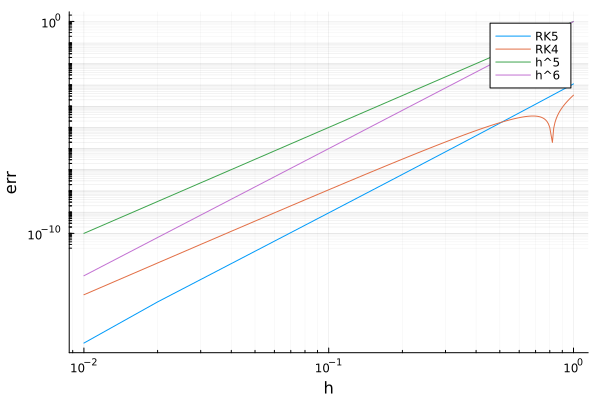

In [10]:
using Plots
hs = 0.01:0.01:1.0

function LTErk1(h)
    yBest = RKStep([1.0],h,test,RKF45)[1]
    abs(yBest-exp(h))
end
function LTErk2(h)
    yBest = RKStep([1.0],h,test,RKF45)[2]
    abs(yBest-exp(h))
end

plot(hs,[LTErk1.(hs) LTErk2.(hs) hs.^5 hs.^6],
xlabel="h", ylabel="err",
xscale=:log10, yscale=:log10, minorgrid=true, label=["RK5" "RK4" "h^5" "h^6"])

# Error Estimates and Step Size Control.

The embedded RK schemes have two different solvers (with different orders $p_{high} > p_{low}$ and constants $C_{high}$ and $C_{low}$) that use the same set of slopes. The difference between these two solutions gives an estimate for the error in a single step.

$$
y_{low} - y_{high} = y_{low}-y_{exact} - (y_{high} - y_{exact}) 
= C_{low} h^{p_{low} +1} - C_{high} h^{p_{high} + 1} + O(h^{p_{low}+2}) +O(h^{p_{high}+2})
= C_{low} h^{p_{low} +1}+ O(h^{p_{low}+2})
$$

1. We can check directly (using the two solvers) if a step has a small error: $|y_{low} - y_{high}|<tol$.
2. If $|y_{low} - y_{high}|\approx C_{low} h^{p_{low} +1} <tol$ then you can estimate how much larger a step $\gamma h$ you could have taken
by solving
$$
C_{low} (\gamma h)^{p_{low} +1}= C_{low} h^{p_{low} +1} \gamma^{p_{low}+1}=tol
$$ 

The standard step size control for an embedded RK scheme is:
1. Take a step of size $h$ from $y_{old}$ and evaluate the low and high accuracy solutions $y_{low}$ and $y_{high}$ and compute the error 
estimate $\Delta = |y_{low} - y_{high}|$
    1. If the $\Delta > tol$ retry the step with the smaller stepsize $0.5 h$ from $y_{old}$.  The backtracking factor $0.5$ is the 
    most common choice.   
    2. If the $\Delta < tol$ take the step using the more accurate solution $y_{high}$ and increase the step size 
    for the next step to $0.9 \gamma h$ where $ \gamma^{p_{low}+1} \Delta = tol$.  The safety factor $0.9$ is the most common choice. 
    
# Embedded Stepper Design and Implementation